# COURSE: A deep understanding of deep learning
## SECTION: Regularization
### LECTURE: CodeChallenge: Effects of mini-batch size
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202305

In [82]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns

# libraries for partitioning and batching the data
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


# Things related to data

In [83]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url,sep=';')
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [84]:
# list number of unique values per column
ovalues = {}
for i in data.keys():
  ovalues[i] = len(np.unique(data[i]))
  
# pretty print the dictionary:
import json
print(json.dumps(ovalues, indent=4))

{
    "fixed acidity": 96,
    "volatile acidity": 143,
    "citric acid": 80,
    "residual sugar": 91,
    "chlorides": 153,
    "free sulfur dioxide": 60,
    "total sulfur dioxide": 144,
    "density": 436,
    "pH": 89,
    "sulphates": 96,
    "alcohol": 65,
    "quality": 6
}


## Normalization

In [85]:
### z-score all variables except for quality

# find the columns we want to normalize (all except quality)
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')

# z-score (written out for clarity)
for col in cols2zscore:
  meanval   = np.mean(data[col])
  stdev     = np.std(data[col],ddof=1)
  data[col] = (data[col]-meanval) / stdev

# can also do more compactly
#data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1599.000000
mean,3.554936e-16,1.688594e-16,-1.066481e-16,-1.110917e-16,3.554936e-16,-6.221137e-17,2.666202e-17,-3.469617e-14,2.861723e-15,6.665504e-16,7.109871e-17,5.636023
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.807569
min,-2.136377e+00,-2.277567e+00,-1.391037e+00,-1.162333e+00,-1.603443e+00,-1.422055e+00,-1.230199e+00,-3.537625e+00,-3.699244e+00,-1.935902e+00,-1.898325e+00,3.000000
25%,-7.004996e-01,-7.696903e-01,-9.290275e-01,-4.530767e-01,-3.711129e-01,-8.484502e-01,-7.438076e-01,-6.075656e-01,-6.549356e-01,-6.380200e-01,-8.661079e-01,5.000000
50%,-2.410190e-01,-4.367545e-02,-5.634264e-02,-2.402999e-01,-1.798892e-01,-1.792441e-01,-2.574163e-01,1.759533e-03,-7.210449e-03,-2.250577e-01,-2.092427e-01,6.000000
75%,5.056370e-01,6.264921e-01,7.650078e-01,4.340257e-02,5.382858e-02,4.899619e-01,4.721707e-01,5.766445e-01,5.757422e-01,4.238832e-01,6.352984e-01,6.000000
max,4.353787e+00,5.876138e+00,3.742403e+00,9.192806e+00,1.112355e+01,5.365606e+00,7.372847e+00,3.678904e+00,4.526866e+00,7.916200e+00,4.201138e+00,8.000000


C:\Users\valdez\AppData\Local\Temp\ipykernel_14444\685604613.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


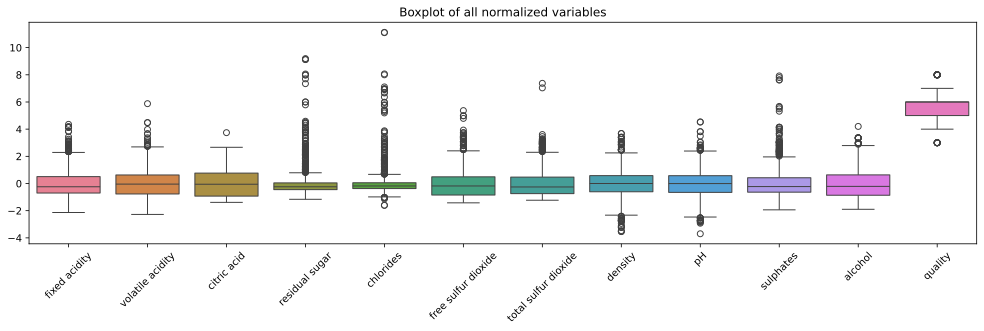

In [86]:
# check the plot again
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.title('Boxplot of all normalized variables')
plt.show()

## Labels Binarization

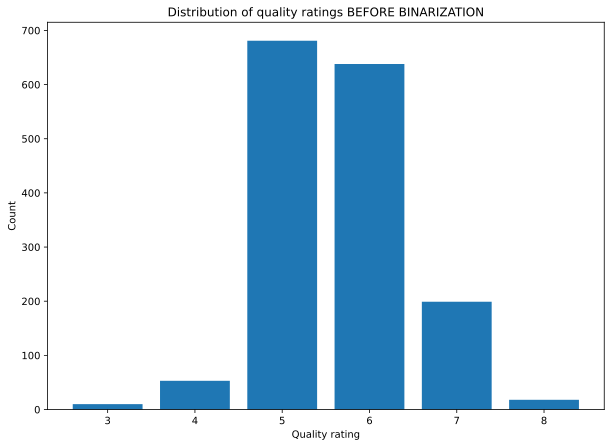

C:\Users\valdez\AppData\Local\Temp\ipykernel_14444\2091588452.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["boolQuality"][data["quality"] > 5] = 1


,quality,boolQuality
0,5,0
1,5,0
2,5,0
3,6,1
4,5,0
...,...,...
1594,5,0
1595,6,1
1596,6,1
1597,5,0


In [87]:
# distribution quality values
fig = plt.figure(figsize=(10, 7))
# plt.rcParams.update({'font.size': 22}) # increase font size in the figure

counts = data["quality"].value_counts()
plt.bar(list(counts.keys()), counts)
plt.xlabel("Quality rating")
plt.ylabel("Count")
plt.title("Distribution of quality ratings BEFORE BINARIZATION")
plt.show()

# create a new column for binarized (boolean) quality
data["boolQuality"] = 0
# data['boolQuality'][data['quality'] < 6] = 0 # implicit in the code! just here for clarity
data["boolQuality"][data["quality"] > 5] = 1

data[["quality", "boolQuality"]]


In [88]:
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,boolQuality
0,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025,-0.959946,5,0
1,-0.298454,1.966827,-1.391037,0.043403,0.223805,0.872365,0.624168,0.028252,-0.719708,0.128910,-0.584594,5,0
2,-0.298454,1.296660,-1.185699,-0.169374,0.096323,-0.083643,0.228975,0.134222,-0.331073,-0.048074,-0.584594,5,0
3,1.654339,-1.384011,1.483689,-0.453077,-0.264878,0.107558,0.411372,0.664069,-0.978798,-0.461036,-0.584594,6,1
4,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025,-0.959946,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,-1.217415,0.403103,-0.980362,-0.382151,0.053829,1.541571,-0.075020,-0.978459,0.899605,-0.461036,0.072271,5,0
1595,-1.389721,0.123866,-0.877693,-0.240300,-0.541090,2.210777,0.137777,-0.861893,1.353012,0.600867,0.729136,6,1
1596,-1.159980,-0.099523,-0.723690,-0.169374,-0.243630,1.254769,-0.196617,-0.533387,0.705287,0.541872,0.541460,6,1
1597,-1.389721,0.654416,-0.775024,-0.382151,-0.264878,1.541571,-0.075020,-0.676446,1.676875,0.305894,-0.209243,5,0


### Normalized data (Pandas df) -> to Tensor
### Binarized labels (Pandas df column) -> to Tensor

In [89]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()

print( dataT.shape )
print( labels.shape )
print(labels)
# we'll actually need the labels to be a "tensor"
labels = labels[:,None]

print('\n--- after adding a dimension ---\n')
print( labels.shape )
print(labels)

torch.Size([1599, 11])
torch.Size([1599])
tensor([0., 0., 0.,  ..., 1., 0., 1.])

--- after adding a dimension ---

torch.Size([1599, 1])
tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [0.],
        [1.]])


# Split ==> TensorDataset ==> DataLoader

In [90]:
# use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(
    dataT, labels, test_size=0.1
)


# then convert them into PyTorch Datasets (note: already converted from pandas datasets to tensors)
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)


# finally, translate into dataloader objects
batchsize = 64
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [91]:
# check sizes of data batches
for X, y in train_loader:
    print(X.shape, y.shape)

# go back and set drop_last=True in training DataLoader

torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])


# Things related to the model

In [92]:
# a function that creates the ANN model
def createANewModel():
    # model architecture
    ANNWine = nn.Sequential(
        nn.Linear(11, 64),  # input layer
        nn.ReLU(),  # activation unit
        nn.Linear(64, 64),  # hidden layer
        nn.ReLU(),  # activation unit
        # labels are binarized, so we only need one output unit
        nn.Linear(64, 1),  # output units
        # nn.Softmax(dim=1), # final activation unit (you probably don't need more reminders that this is just conceptual ;)  )
    )

    # loss function
    lossfun = (
        nn.BCEWithLogitsLoss()
    )  # we choose cross-entropy loss here because we have a classification task

    # optimizer
    optimizer = torch.optim.SGD(ANNWine.parameters(), lr=0.005)

    return ANNWine, lossfun, optimizer

# Train the model

In [93]:
# train the model

def trainTheModel(model, lossfun, optimizer, numepochs=100):
    # initialize accuracies as empties
    trainAcc = []
    testAcc = []
    losses = []

    # loop over epochs
    for epochi in range(numepochs):

        # loop over batches
        for X, y in train_loader:
            # forward pass and loss
            yHat = model(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # end of batch loop...

        ### train accuracy
        accu = torch.mean((torch.argmax(model(X), axis=1) == y).float())
        trainAcc.append(accu.item())
        losses.append(loss.item())

        ### test accuracy

        # extract X,y from test dataloader
        X, y = next(iter(test_loader))

        # activate testing mode
        predlabels = torch.argmax(model(X), axis=1)

        # compute accuracy
        testAcc.append(100 * torch.mean((predlabels == y).float()).item())

    # function output
    return trainAcc, testAcc, losses

In [94]:
# Train the model
ANNWine, lossfun, optimizer = createANewModel()
trainAcc, testAcc, losses = trainTheModel(ANNWine, lossfun, optimizer, numepochs=250) # train the model

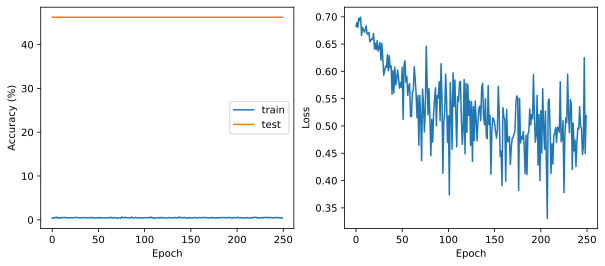

In [95]:
# plot the accuracies and losses
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(trainAcc,label='train')
ax[0].plot(testAcc,label='test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy (%)')
ax[0].legend()
ax[1].plot(losses)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()



# Minibatches experiment

# Run the experiment and visualize the results

In [ ]:
# range of batch sizes
batchsizes = 2**np.arange(1,7)

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs,len(batchsizes)))
accuracyResultsTest  = np.zeros((numepochs,len(batchsizes)))

# test data doesn't vary by training batch size
test_loader = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

# loop over batch sizes
for bi in range(len(batchsizes)):

  # create dataloader object
  train_loader = DataLoader(train_dataDataset,
                          batch_size=int(batchsizes[bi]), shuffle=True, drop_last=True)

  # create and train a model
  ANNiris,lossfun,optimizer = createANewModel()
  trainAcc,testAcc,losses = trainTheModel()

  # store results
  accuracyResultsTrain[:,bi] = trainAcc
  accuracyResultsTest[:,bi]  = testAcc

In [ ]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
  ax[i].legend(batchsizes)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,101])
  ax[i].grid()

plt.show()

# Additional explorations

In [ ]:
# 1) Why are the minibatch sizes specified in powers of 2? That's partly because DL is developed by math/computer nerds,
#    but it's also partly an attempt to optimize computation speed, because computer memory comes in powers of two.
#    But 2**N is not a specific requirement. Adjust the code to use batch sizes corresponding to six linearly spaced 
#    integers between 2 and 50.
# 
# 2) Why did I ask you to set the learning rate to .001? Try this experiment again using higher and lower learning rates.
#    What do you conclude about batch sizes and learning rate?
# 